In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import optimize
from joblib import Parallel, delayed

import generator
import sde

Stock process:
$$ S^{(i)}_t=S^{(i)}_0exp{(r-\frac{\sigma^2_i}{2})t+\sigma_iW_t},i=1,...d      $$

Option:
$$(max{S_T^{(1)},...,S_T^{((d))}-K})^+ $$

Option value under Q measure:
$$v=E_Q[e^{-rT}(max\{S^{(1)}_T,...,S_T^{(d)}\}-K)^+] $$

In this project, $d=5$, $S^{(1)}_0=45$, $S^{(2)}_0=50$, $S^{(3)}_0=45$, $S^{(4)}_0=55$, $r=0.02$, $T=0.5$

$\sigma1=\sigma2=\sigma3=0.1$, $=\sigma4=0.2$, $\Sigma=\begin{bmatrix}1.0&0.3&-0.2&0.4\\0.3&1.0&-0.3&0.1\\-0.2&-0.3&1.0&0.5\\0.4&0.1&0.5&1.0\end{bmatrix}$ 


In [2]:
#1.cholseky decomposition
A=np.array([[1,0.3,-0.2,0.4],[0.3,1,-0.3,0.1],[-0.2,-0.3,1,0.5],[0.4,0.1,0.5,1]])
L1,L2=generator.CholeskyDecomposition(A)
print(L1)

[[ 1.          0.          0.          0.        ]
 [ 0.3         0.9539392   0.          0.        ]
 [-0.2        -0.25158836  0.94694419  0.        ]
 [ 0.4        -0.0209657   0.60692624  0.68644081]]


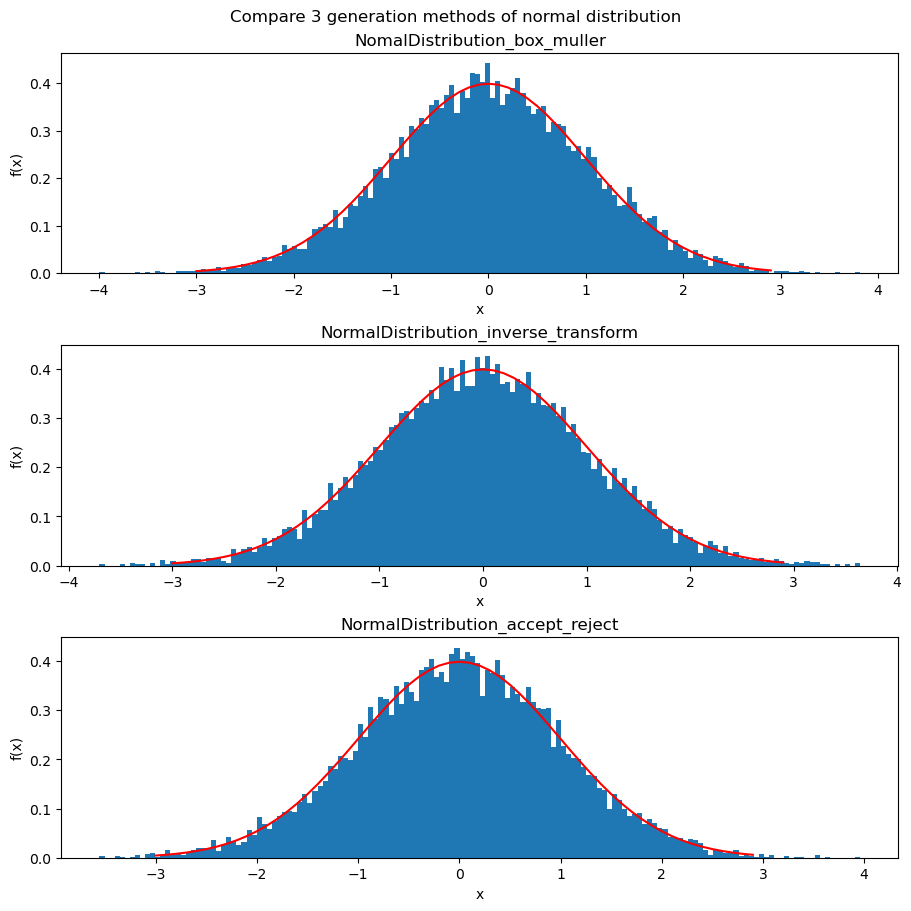

In [3]:
#2.compare 3 generation methods of normal distribution
def plot_normal(ax,fun,n=10000,seed=100):
    generated=list(fun(n,seed))
    ax.hist(generated,bins=150,density=True)
    ax.plot([i*0.1 for i in range(-30,30)],norm.pdf([i*0.1 for i in range(-30,30)]),color='red')
    ax.set_title(fun.__name__)
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    return generated

fig, axs = plt.subplots(3,1 , figsize=(9, 9),dpi=100,constrained_layout=True)
fig.suptitle('Compare 3 generation methods of normal distribution')
bm=plot_normal(axs[0],generator.NomalDistribution_box_muller)
it=plot_normal(axs[1],generator.NormalDistribution_inverse_transform)
ar=plot_normal(axs[2],generator.NormalDistribution_accept_reject)

In [4]:
#Acceptance-Rejection method is the one with least bias
#Box-Muller method is the one with least variance
print("Box-Muller method, mean:",np.mean(bm),"std:",np.std(bm))
print("Inverse Transform method, mean:",np.mean(it),"std:",np.std(it))
print("Acceptance-Rejection method, mean:",np.mean(ar),"std:",np.std(ar))

Box-Muller method, mean: 0.007781642688470848 std: 1.0014749514806924
Inverse Transform method, mean: 0.0031973149274610486 std: 1.0041092516871977
Acceptance-Rejection method, mean: -0.0008905135998795459 std: 1.005568992047348


In [5]:
#Compare the result with different number of samples
r=0.02
sigma_list=[0.1,0.1,0.1,0.2]
S0_list=[45,50,45,55]
T=0.5
n_list=[2500,5000,10000,20000,40000,80000]
cov_matrix=np.array([[1,0.3,-0.2,0.4],[0.3,1,-0.3,0.1],[-0.2,-0.3,1,0.5],[0.4,0.1,0.5,1]])
K=50
H_list=[sde.OptionPricingResultGBM(r,sigma_list,S0_list,T,n,cov_matrix,K) for n in n_list]

for i in range(len(n_list)):
    print("n=",n_list[i],"mean:",np.mean(H_list[i]),"std:",np.std(H_list[i])/np.sqrt(n_list[i]))

n= 2500 mean: 7.018661058941734 std: 0.12333462887403077
n= 5000 mean: 7.056618584600497 std: 0.08824800643032378
n= 10000 mean: 7.008757938677544 std: 0.06260818623372855
n= 20000 mean: 7.00171430553618 std: 0.04404566635186428
n= 40000 mean: 7.015770224111469 std: 0.03122820850267693
n= 80000 mean: 7.015286536418632 std: 0.02209345328277046


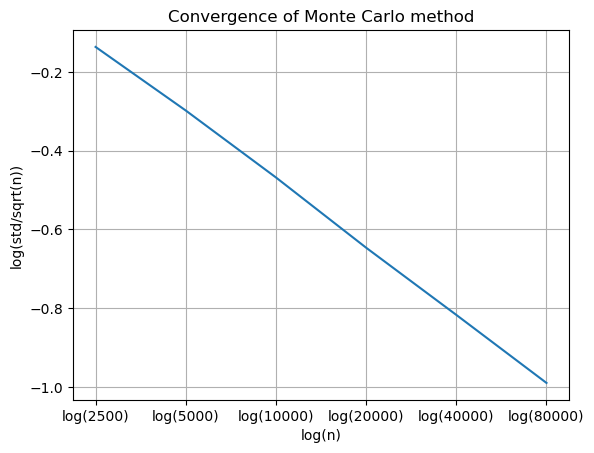

In [6]:
#Plot the estimates of option value against log n and deduce the order of convergence with respect to n
plt.plot([np.log(n) for n in n_list],[np.log(np.std(H)/np.sqrt(n)**0.5) for H,n in zip(H_list,n_list)])
plt.xticks([np.log(n) for n in n_list],[f"log({n})" for n in n_list])
plt.xlabel("log(n)")
plt.ylabel("log(std/sqrt(n))")
plt.title("Convergence of Monte Carlo method")
plt.grid()

In [7]:
#Examine the ratio of standard error to estimate
r=0.02
sigma_list=[0.1,0.1,0.1,0.2]
S0_list=[45,50,45,55]
T=0.5
n=20000
cov_matrix=np.array([[1,0.3,-0.2,0.4],[0.3,1,-0.3,0.1],[-0.2,-0.3,1,0.5],[0.4,0.1,0.5,1]])
K_list=[50+i*5 for i in range(7)]
H_list=[sde.OptionPricingResultGBM(r,sigma_list,S0_list,T,n,cov_matrix,K) for K in K_list]

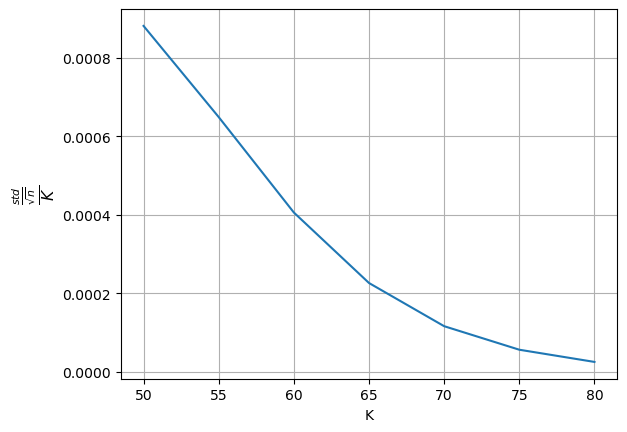

In [9]:
plt.plot(K_list,[np.std(H)*n**-0.5/K_list[i] for i,H in enumerate(H_list)])
plt.grid()
plt.xlabel("K")
plt.ylabel(r"$\frac{\frac{std}{\sqrt{n}}}{K} $", fontsize=16)
plt.show()

In [14]:
#Apply the antithetic variate method and compare
r=0.02
sigma_list=[0.1,0.1,0.1,0.2]
S0_list=[45,50,45,55]
T=0.5
n=20000
cov_matrix=np.array([[1,0.3,-0.2,0.4],[0.3,1,-0.3,0.1],[-0.2,-0.3,1,0.5],[0.4,0.1,0.5,1]])
K_list=[50+i*5 for i in range(7)]

In [15]:
#multiprocessing is used to speed up the calculation(as we know, multithreading is useless in python due to GIL)
H_list_basic=Parallel(n_jobs=-1)(delayed(sde.OptionPricingResultGBM)(r,sigma_list,S0_list,T,n,cov_matrix,K) for K in K_list)
H_list_stratified=Parallel(n_jobs=-1)(delayed(sde.OptionPricingResultGBM_stratified)(r,sigma_list,S0_list,T,n,cov_matrix,K) for K in K_list)
H_list_antithetic=Parallel(n_jobs=-1)(delayed(sde.OptionPricingResultGBM_antithetic)(r,sigma_list,S0_list,T,n,cov_matrix,K) for K in K_list)
H_list_antithetic_stratified=Parallel(n_jobs=-1)(delayed(sde.OptionPricingResultGBM_antithetic_stratified)(r,sigma_list,S0_list,T,n,cov_matrix,K) for K in K_list)

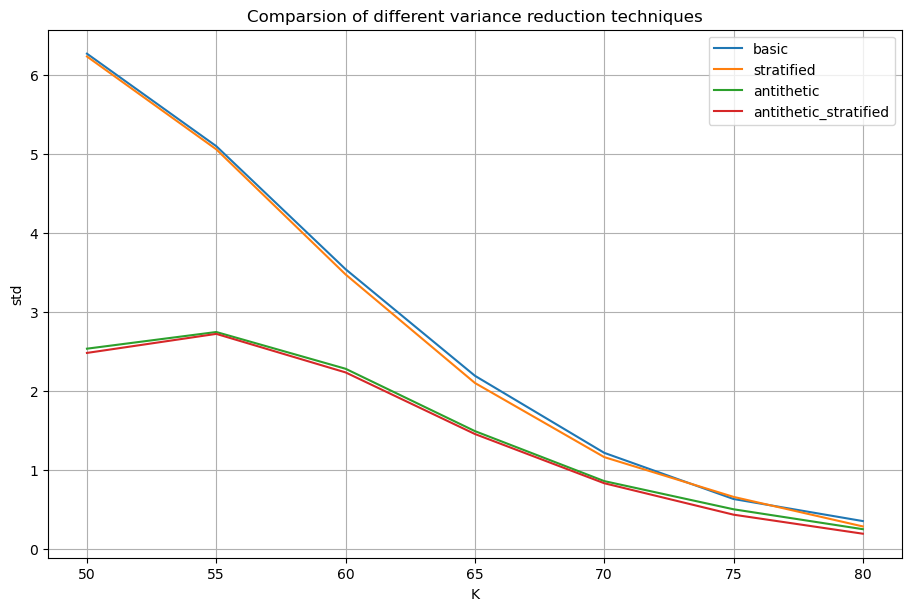

In [16]:
fig,ax=plt.subplots(1,1,figsize=(9, 6),dpi=100,constrained_layout=True)
ax.plot(K_list,[np.std(H) for H in H_list_basic],label="basic")
ax.plot(K_list,[np.std(H) for H in H_list_stratified],label="stratified")
ax.plot(K_list,[np.std(H) for H in H_list_antithetic],label="antithetic")
ax.plot(K_list,[np.std(H) for H in H_list_antithetic_stratified],label="antithetic_stratified")
ax.legend()
ax.set_xlabel("K")
ax.set_ylabel("std")
ax.set_title("Comparsion of different variance reduction techniques")
ax.grid()
plt.show()


Simulation about SDE

Euler Method: 
$$\frac{dS_t}{S_t}=r_tdt+\sigma_t dW_t  $$
Milstein Method:
$$ X_{t_{j+1}}=X_j+\mu(x_j,t_j)\Delta t_j+\sigma (X_j,t_j)\sqrt{\Delta t_j}Z_j+\frac{\sigma (X_{t_j}) \sigma ^{'} (X_{t_j})  }{2} \Delta t_j(Z^{2}_j -1)   $$

Milstein Method with Runge-Kutta:
$$\hat{X_i}=X_i+\mu (X_i)\Delta t + \sigma (X_i)\sqrt{\Delta t}  $$
$$X_{i+1}=X_i+\mu (X_i)\Delta t + \sigma (X_i)+\frac{1}{2\sqrt{\Delta t}} [\sigma (\hat{X_i}-\sigma(X_i))][(\Delta W_i)^2 - \Delta t ]   $$

In [24]:
r=0.12;sigma=0.2;T=1;X0=50;delta_t=0.01;n=10000;m=int(T/delta_t)
def benchmark(r,sigma,X0,delta_t,m):
    z=np.random.normal(0,1,m)
    for i in range(m):
        X0=X0*np.exp((r-0.5*sigma**2)*delta_t+sigma*np.sqrt(delta_t)*z[i])
    return X0


def Euler(r,sigma,X0,delta_t,m):
    z=np.random.normal(0,1,m)
    for i in range(m):
        X0=X0*(1+r*delta_t+sigma*np.sqrt(delta_t)*z[i])
    return X0

def Milstein(r,sigma,X0,delta_t,m):
    z=np.random.normal(0,1,m)
    for i in range(m):
        X0=X0*(1+r*delta_t+sigma*np.sqrt(delta_t)*z[i]+0.5*sigma**2*delta_t*(z[i]**2-1))
    return X0

benchmark_list=[benchmark(r,sigma,X0,delta_t,m) for i in range(n)]
Euler_list=[Euler(r,sigma,X0,delta_t,m) for i in range(n)]
Milstein_list=[Milstein(r,sigma,X0,delta_t,m) for i in range(n)]

print("benchmark mean:",np.mean(benchmark_list),"std:",np.std(benchmark_list))
print("Euler mean:",np.mean(Euler_list),"std:",np.std(Euler_list))
print("Milstein mean:",np.mean(Milstein_list),"std:",np.std(Milstein_list))


benchmark mean: 56.585486423463585 std: 11.393721844743178
Euler mean: 56.44346569205462 std: 11.435067495877663
Milstein mean: 56.41630284663165 std: 11.385798134838282


In [156]:
#American Option Backwards Pricing Regression Method
#Put option S0=1, K=1.1, r=0.06, sigma=0.1, T=3, n=20000
sample=100
price_path=np.random.randn(sample,3)*0.1**0.5
price_path=np.cumsum(price_path,axis=1)+1
price_path=np.where(price_path<0,0,price_path)
option_path=(1.1-price_path).clip(min=0)
in_the_money=option_path[option_path[:,1]>0,]
x_panel=np.concatenate([np.ones((in_the_money.shape[0],1)),np.cumprod(np.tile(in_the_money[:,1],(2,1)).T,axis=1)],axis=1)
y_panel=(in_the_money[:,2]*np.exp(-0.06)).reshape(-1,1)
ols_para=np.linalg.inv(x_panel.T@x_panel)@x_panel.T@y_panel
continue_value=x_panel@ols_para
backward_value=np.sum(np.max(np.concatenate((continue_value,y_panel),axis=1),axis=1))/sample
backward_value

In [31]:
#important sampling for binary call option
#mode matching
S0=50;r=0.01;sigma=0.1;T=1;K=80;n=20000
b=(np.log(K/S0)-(r-sigma**2/2)*T)/(sigma*T**0.5)
random_set=generator.NormalDistribution_accept_reject(n)
x_star=max(0,b)
random_set=[x_star+i for i in random_set]
for i in range(len(random_set)):
    if random_set[i]<b:
        random_set[i]=0
    else:
        random_set[i]=np.exp(-r*T-x_star*random_set[i]+x_star**2/2)
value=np.mean(random_set)
print("estimation mean:",np.mean(random_set),"\testimation std",np.std(random_set),\
    "\nRelative Eroor:",np.std(random_set)/np.mean(random_set))

estimation mean: 1.6426534932530085e-06 	estimation std 3.7633274989392914e-06 
Relative Eroor: 2.2910050807408155


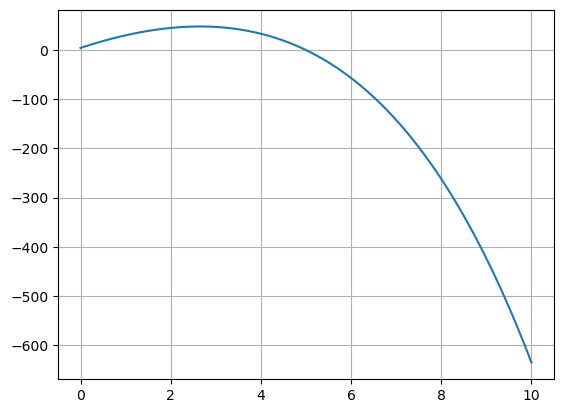

In [4]:
#important asmpling for call option(deep out of money)
#to find the z=argmax{h(z)f(z)}
S0=30;r=0.05;sigma=0.2;T=0.5;K=60;n=100000
target_fun=lambda z:S0*np.exp((r-sigma**2/2)*T+sigma*T**0.5*z)*(sigma*T**0.5)-z*(S0*np.exp((r-sigma**2/2)*T+sigma*T**0.5*z)-K)
plt.plot(np.linspace(0,10,100),[target_fun(z) for z in np.linspace(0,10,100)])
plt.grid()
z=optimize.newton(target_fun,4)

In [5]:
random_set=generator.NormalDistribution_accept_reject(n)
random_set=[i+z for i in random_set]
random_set=[np.exp(-r*T-z*i+z**2/2)*np.max((S0*np.exp((r-sigma**2/2)*T+sigma*T**0.5*i)-K,0)) for i in random_set]

print("estimation mean:",np.mean(random_set),"\testimation std",np.std(random_set),\
    "\nRelative Eroor:",np.std(random_set)/np.mean(random_set))

estimation mean: 1.3341768686577687e-06 	estimation std 2.058401985118877e-06 
Relative Eroor: 1.5428254180344958


Portfolio Credit Risk in Gaussian Copula model
Gaussian Copula Model provides a mechanism for specifying the dependence among the default indicators, and each indicator can be represented as:
$$Y_k=\mathbb{1}\{\xi_k>x_k\}, k=1,...m$$

$x_k$ is the default threshold and $\xi_k$ is credit index, where 
$$\xi_k=a_{k1}Z_1+...+a_{kd}Z_d+b_k\epsilon_k$$
$Z_1...Z_d$ are systematic risk factors that i.i.d r.v with N(0,1), $\epsilon_k$ is idiosyncratic risk factor, N(0,1) as well.


asumme $\xi_k$ have a normal distribution and set $p_k=P[\xi_k>x_k]$, the we obtian $x_k=\phi^{-1}(1-p_k)$, where $\phi$ is the cdf of normal dist. In summary:
$$P(Y_k=1)=P(\xi_k>\phi^{-1}(1-p_k))=1-\phi(\phi^{-1}(1-p_k))=p_k$$ 


The conditinal defacult probability for kth obligor conditinal on factor loadings: $\textbf{Z}=(Z_1...Z_d)^T$ is
$$p_k(\textbf{Z})=P(Y_k=1|\textbf{Z}=P(\xi_k>x_k|\textbf{Z})$$

observing $\epsilon_k=\frac{\xi_k-\textbf{a}_k\textbf{Z}}{b_k}$ and $x_k=\phi^{-1}(1-p_k)$, we have

$$p_k(\textbf{Z})=P(\epsilon_k>\frac{\phi^{-1}(1-p_k)-\textbf{a}_k\textbf{Z}}{b_k})$$
$$=\phi(\frac{\textbf{a}_k\textbf{Z}+\phi^{-1}(p_k)}{b_k})$$
where $p_k$ is the unconditional default probability


In [18]:
m=3#asset number
c1=2;c2=1;c3=4#loss given default
rho1=0.2;rho2=0.5;rho3=0.8#correlation between systematic and idiosyncratic risk
x1=1;x2=1;x3=2#thershold
n=10000#sample size
h=4#portfolio loss threshold
normal_set=generator.NormalDistribution_accept_reject(n*(m+1))
H_list=[]
for i in range(n):
    #cholesky decomposition is used to generate correlated normal distribution
    L=c1*((normal_set[4*i]*rho1+normal_set[4*i+1]*(1-rho1**2)**0.5)>x1)+\
        c2*((normal_set[4*i]*rho2+normal_set[4*i+2]*(1-rho2**2)**0.5)>x2)+\
            c3*((normal_set[4*i]*rho3+normal_set[4*i+3]*(1-rho3**2)**0.5)>x3)
    H_list.append(L>h)
print("estimation mean:",np.mean(H_list),"\testimation std",np.std(H_list)/n**0.5,\
    "\nrelative error:",np.std(H_list)/n**0.5/np.mean(H_list))

estimation mean: 0.0144 	estimation std 0.0011913286700151223 
relative error: 0.08273115763993906


Exponential tilt method. 
We use the likelihood ratio relating the original and new probabilit to correct the change in distribution of importance sampling.
$$\mathcal{l}=\prod^m_{k=1}(\frac{p_k}{q_k})^{Y_k}(\frac{1-p_k}{1-q_k})^{1-Y_k}$$
$$ln\ \mathcal{l}=\sum^m_{k=1}Y_kln\frac{p_k}{q_k}+(1-Y_k)ln\frac{1-p_k}{1-q_k}$$


Generate the default indicators $Y_k$ from new probability and evaluating the new portfolio loss. Apply exponential twist to the dist of $Y_kv_k$, which means multiplying the value of a probability density at every point x by a factor $exp(\theta x)$
Let f denote the density of X. The exponential tilt family consists of probability distribution with density:
$$f_{\theta}(x)=\frac{1}{E[e^{\theta x}]}e^{\theta x} f(x)$$

Exponential tilt under Bernuolli variable. The increments $Y_kv_k$ takes two values stisfying Bernuolli varibale. Apply an exponential tilt on it.
$$q_k=p_k(\theta)=\frac{p_k e^{\theta v_k}}{p_k e^{\theta v_k}+(1-p_k)}$$
$$1-q_k=1-p_k(\theta)=\frac{1-p_k}{p_k e^{\theta v_k}+(1-p_k)}$$
$$ln\ l=\sum^m_{k=1}ln(1+p_k(e^{\theta v_k}-1))-\sum^m_{k=1}\theta Y_k  $$
$$E[exp(\theta L)]=E[e^{\theta (Y_1+...Y_m)}]=\prod^m_{k=1} E[e^{\theta Y_k}]=\prod^m_{k=1} [(1-p_k)+p_ke^{v_k \theta}] (moment gneration function for Bernoulli)$$

$\psi_L$ is the cumulant generating function, likelihood ratio is decreasing in L for all $\theta$>0, which is attracting because make likelihood ratio small on the event $\{L>x\}$ can help variance reducing

$$\psi_L(\theta)=ln E[exp(\theta L)]=\sum^{m}_{k=1} ln(1+p_k(e^{v_k \theta}-1)$$
$$l=exp(-\theta L+\psi_L(\theta))$$


using the relations:$E[e^{\theta L}]=e^{\psi_L(\theta)} $ and $l=e^{-\theta L+\psi(\theta)}$

$$\psi^{'}_L=\frac {E[Le^{\theta L}]}{E[e^{\theta L}]}=\frac{E[Le^{\theta L}]}{e^{\psi_L(\theta)}}=E[e^{-\psi(\theta)Le^{\theta L}}]=E_{\theta}[{Le^{\theta L-\psi_L(\theta)}}e^{-\theta L+\psi_L(\theta)}]=E_{\theta}[L]$$
$$E_{\theta_{x}}[L]=E{\theta_{x}}[\sum^m_{k=1}Y_kv_k]=\psi^{'}(\theta _x)=x$$
solve for $\theta _x$ from solution of the equation: $\psi^{'}_L(\theta x)=x$

$$m=1000, p_k=0.01(1+e^{-k/m}), k=1,2,...m$$
All losses are equal to one. The sample size is $n=10000$